In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from bspline_activation import LearnableBSplineActivation

class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class model2(nn.Module):
    def __init__(self):
        super(model2, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

        self.activation1 = LearnableBSplineActivation(start_point=-1, end_point=1)
        self.activation2 = LearnableBSplineActivation(start_point=-1, end_point=1)

    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.activation2(self.fc2(x))
        x = self.fc3(x)
        return x

In [2]:
import numpy as np
import random
n_peak = 5
n_num_per_peak = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(0)

In [3]:
def fit(inputs, targets, model, optimizer, val_inputs=None, val_targets=None, patience=200, min_delta=0.001):
    inputs, targets = inputs.to(device), targets.to(device)
    if val_inputs is not None and val_targets is not None:
        val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

    criterion = nn.MSELoss()
    optimizer = optimizer(model.parameters(), lr=0.003)

    for epoch in range(1000):
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

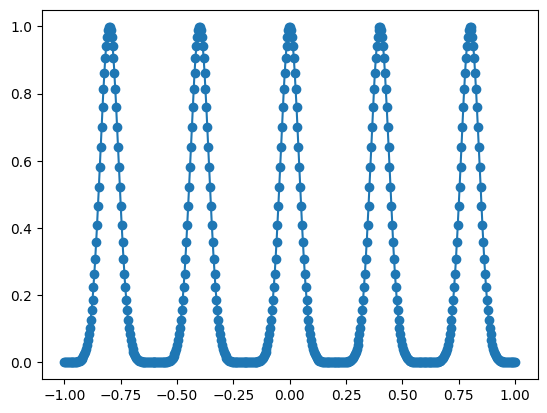

In [4]:
n_sample = n_peak * n_num_per_peak
x_grid = torch.linspace(-1,1,steps=n_sample)
x_centers = 2/n_peak * (np.arange(n_peak) - n_peak/2+0.5)
x_sample = torch.stack([torch.linspace(-1/n_peak,1/n_peak,steps=n_num_per_peak)+center for center in x_centers]).reshape(-1,)
y = 0.
for center in x_centers:
    y += torch.exp(-(x_grid-center)**2*300)
y_sample = 0.
for center in x_centers:
    y_sample += torch.exp(-(x_sample-center)**2*300)


plt.plot(x_grid.detach().numpy(), y.detach().numpy())
plt.scatter(x_sample.detach().numpy(), y_sample.detach().numpy())

In [5]:
def regression_experiment(model, optimizer):
    ys = []
    for group_id in range(n_peak):
        dataset = {}
        dataset['train_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
        dataset['train_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
        dataset['test_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
        dataset['test_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
        fit(dataset['train_input'], dataset['train_label'], model, optimizer)
        y_pred = model(x_grid[:,None])
        ys.append(y_pred.detach().numpy()[:,0])
    return ys


ys2 = regression_experiment(model2(), torch.optim.SGD) # Learnable B-Spline
ys1 = regression_experiment(model1(), torch.optim.Adam) # Simple ReLU

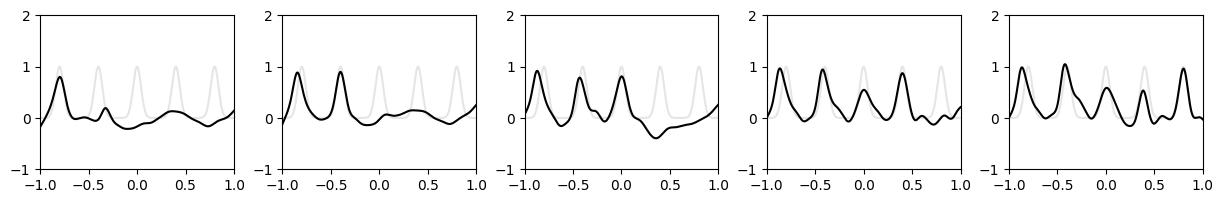

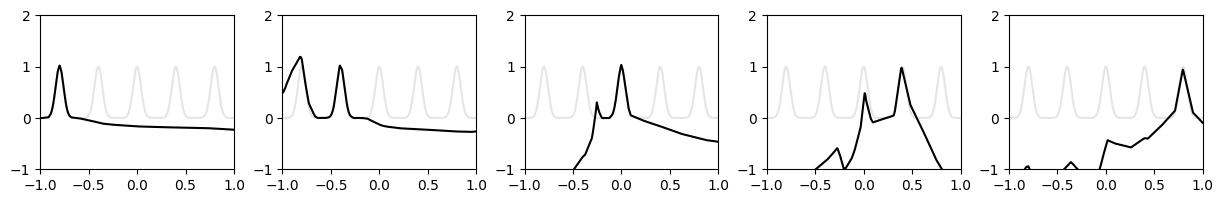

In [6]:
def plot(ys):
    # Plotting
    plt.subplots(1, n_peak, figsize=(15, 2))
    plt.subplots_adjust(wspace=0.25, hspace=0)
    for i in range(1,n_peak+1):
        plt.subplot(1,n_peak,i)
        plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
        plt.plot(x_grid.detach().numpy(), ys[i-1], color='black')
        plt.xlim(-1,1)
        plt.ylim(-1,2)
plot(ys2)
plot(ys1)